In [82]:
import os
import kagglehub
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [37]:
np.random.seed(42)

#### Utility functions

In [38]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float32', 'float64']  # Removed float16
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                # Skip float16 to avoid overflow issues with pandas display
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [39]:
def visualize_class_distribution(y):
    class0 = (y == 0).sum()
    class1 = (y == 1).sum()

    data = {
        'Class': ['Class 0', 'Class 1'],
        'Count': [class0, class1]
    }

    # Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Class', y='Count', data=data)
    plt.title('Class Distribution (Train Set)')
    plt.show()

In [40]:
def save_model(model, filename):
    # Ensure results folder exists
    folder = "results"
    os.makedirs(folder, exist_ok=True)

    # Build full path
    filepath = os.path.join(folder, filename)

    # Save model
    with open(filepath, 'wb') as file:
        pkl.dump(model, file)

    print(f"Model saved to: {filepath}")

In [41]:
def load_model(filename):
    # Build full path
    filepath = os.path.join("results", filename)

    # Load model
    with open(filepath, 'rb') as file:
        model = pkl.load(file)

    print(f"Model loaded from: {filepath}")
    return model

In [42]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [43]:
def show_classification_report(y_true, y_pred):
    # Generate report as dict
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Convert to DataFrame & transpose
    df = pd.DataFrame(report).transpose().round(4)

    # Reorder rows: class labels first, then accuracy + averages
    row_order = [str(label) for label in sorted(df.index[:-3])] + ["accuracy", "macro avg", "weighted avg"]
    df = df.loc[row_order]

    # Fix accuracy row: put accuracy value in f1-score column
    if "accuracy" in df.index:
        df.loc["accuracy", "precision"] = None
        df.loc["accuracy", "recall"] = None
        df.loc["accuracy", "f1-score"] = report["accuracy"]
    
    # Color encoding for good / medium / bad values
    def color_scale(s):
        colors = []
        for v in s:
            if pd.isna(v):
                colors.append("")  
            elif v >= 0.80:
                colors.append("background-color: rgba(0, 200, 0, 0.35)")   # green
            elif v >= 0.50:
                colors.append("background-color: rgba(255, 165, 0, 0.35)") # yellow/orange
            else:
                colors.append("background-color: rgba(255, 0, 0, 0.35)")   # red
        return colors

    numeric_cols = ["precision", "recall", "f1-score"]
    styled = df.style.apply(color_scale, subset=numeric_cols)

    # Make column headers bold
    styled = styled.set_properties(**{"font-weight": "bold"}, subset=pd.IndexSlice[:, numeric_cols])

    return styled


In [44]:
def train_and_save_model(
    model,
    model_name,
    X_train,
    y_train,
    X_test,
    y_test,
    sampled=False
):
    # ---- Train model ----
    model.fit(X_train, y_train)

    # ---- Predictions ----
    y_pred = model.predict(X_test)

    # ---- Classification Report ----
    report = show_classification_report(y_test, y_pred)

    # ---- Build filename ----
    suffix = "_sampled" if sampled else ""
    filename = f"{model_name}{suffix}.pkl"

    # ---- Save model ----
    save_model(model, filename)

    return model, y_pred, report

In [ ]:
def prepare_model_for_imbalance(model, y_train):
    """
    Automatically configures a model with the best imbalance-handling parameters.

    Works with:
    - LogisticRegression
    - RandomForestClassifier
    - GradientBoostingClassifier
    - AdaBoostClassifier
    - SVC / LinearSVC
    - KNN
    - GaussianNB
    - MLPClassifier
    - XGBClassifier
    - LGBMClassifier
    - CatBoostClassifier
    """

    # compute class weights / imbalance ratio
    counter = Counter(y_train)
    maj = counter[0]
    minr = counter[1]

    imbalance_ratio = maj / minr  # used for scale_pos_weight etc.

    params = {}

    # ----- XGBoost -----
    if model.__class__.__name__ == "XGBClassifier":
        params["scale_pos_weight"] = imbalance_ratio

    # ----- LightGBM -----
    elif model.__class__.__name__ == "LGBMClassifier":
        params["is_unbalance"] = True
        params["scale_pos_weight"] = imbalance_ratio

    # ----- CatBoost -----
    elif model.__class__.__name__ == "CatBoostClassifier":
        params["class_weights"] = [1, imbalance_ratio]

    # ----- Logistic Regression -----
    elif model.__class__.__name__ == "LogisticRegression":
        params["class_weight"] = "balanced"

    # ----- Random Forest -----
    elif model.__class__.__name__ == "RandomForestClassifier":
        params["class_weight"] = "balanced"

    # ----- Gradient Boosting -----
    elif model.__class__.__name__ == "GradientBoostingClassifier":
        params["subsample"] = 1.0  # stabilize on imbalance

    # ----- AdaBoost -----
    elif model.__class__.__name__ == "AdaBoostClassifier":
        params["algorithm"] = "SAMME.R"

    # ----- SVC / LinearSVC -----
    elif model.__class__.__name__ in ["SVC", "LinearSVC"]:
        params["class_weight"] = "balanced"

    # Set parameters dynamically
    for key, value in params.items():
        try:
            setattr(model, key, value)
        except:
            pass

    return model


### Data Collection
- Import the data from Kaggle [Santander Customer Transaction Prediction Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/santander-customer-transaction-prediction-dataset/data)
- Visualize the data: 
    - Check the size and type of data.
- Convert data to practical formats


In [45]:
# Download the dataset first to see what files are available
dataset_path = kagglehub.dataset_download("lakshmi25npathi/santander-customer-transaction-prediction-dataset")

print(f"Dataset downloaded to: {dataset_path}")
print("\nFiles in the dataset:")
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        print(f"  - {file}")


Dataset downloaded to: /Users/olutolaoloruntobipaul/.cache/kagglehub/datasets/lakshmi25npathi/santander-customer-transaction-prediction-dataset/versions/1

Files in the dataset:
  - test.csv
  - train.csv


In [46]:
df = pd.read_csv(os.path.join(dataset_path, "train.csv"))

#### Dataset visualization

In [47]:
df.shape

(200000, 202)

In [48]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


### Exploration Data Analysis (EDA)

- Downsampling a copy of the dataset
- Check data type
- Data cleaning
    - Fill in missing values (empty or NaN) or drop their rows
    - Fix or Remove outliers
- Feature selection
    - Drop non relevant columns
- Feature engineering
    - Possibly discretize continuous features
    - Decompose features (e.g., categorical, date/time)
    - Add promising feature transformations (e.g., log(x), x^2)
    - Aggregate features into promising new features
- Normalization

Data cleaning

In [50]:
#Check empty values in each column
empty = df.isna().sum()
print(empty[empty>0])
# Show rows with any null values
df[df.isnull().any(axis=1)]

Series([], dtype: int64)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199


In [51]:
df['target'].value_counts()

target
0    179902
1     20098
Name: count, dtype: int64

In [52]:
# Remove the ID_code column
df = df.drop(columns=['ID_code'])
df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [53]:
# Remove outliers
total_outliers = 0

# Detect outliers using the IQR method

outlier_indices = set()

for col in df.columns.drop('target'):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_idx = df[outlier_mask].index.tolist()
    
    #print(f"Column: {col}, Outliers detected: {len(outlier_idx)}")
    
    # Add indices to the set (automatically removes duplicates)
    outlier_indices.update(outlier_idx)
    total_outliers += len(outlier_idx)
print(f"Total outliers detected across all columns: {total_outliers}")
print(f"Total unique rows with outliers: {len(outlier_indices)}")

# (Optional) View the unique outlier rows
outlier_rows = df.loc[list(outlier_indices)]
print(f"\nOutlier rows shape: {outlier_rows.shape}")

Total outliers detected across all columns: 26536
Total unique rows with outliers: 24896

Outlier rows shape: (24896, 201)


In [54]:
# Check non numeric columns to transform data into a more efficient type for the training
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
non_numeric_cols

Index([], dtype='object')

In [55]:
# remove outlier rows from the original dataframe
df_cleaned = df.drop(index=outlier_indices)
df_cleaned.shape

(175104, 201)

Split test and train sets

In [56]:
X = df_cleaned.drop(columns=['target'])
y = df_cleaned['target']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

Visualize target values

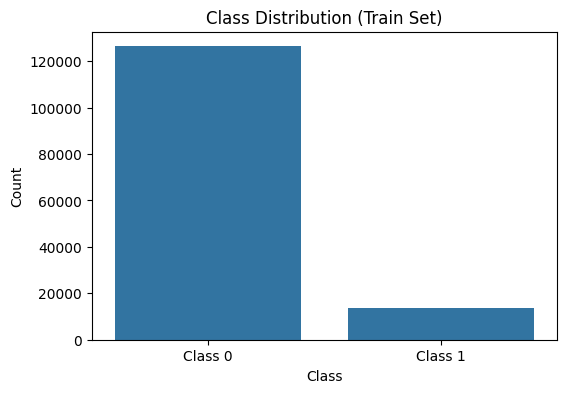

In [58]:
visualize_class_distribution(y_train)

We see an imbalance dataset. Solution:
- Doing downsampling on a copy of the training dataset to evaluate the performance
- Doing class weighted on the models

We don't do upsample because we want to minimize training time.

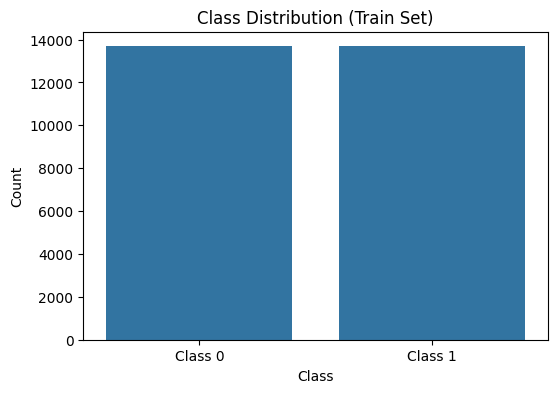

In [59]:
# Downsampling
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
rus = RandomUnderSampler(sampling_strategy='majority')
X_resampled_down, y_resampled_down = rus.fit_resample(X_train_copy, y_train_copy)
visualize_class_distribution(y_resampled_down)

In [60]:
# Class weigthing
class_weights = {0: 1, 1: round((len(y_train) / sum(y_train)),2)}  # Adjust weights based on class distribution
print(f"Class weights: {class_weights}")

Class weights: {0: 1, 1: 10.24}


Correlation matrix

In [61]:
scorr = df_cleaned.corr(numeric_only=True)
scorr

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.000000,0.050677,0.047490,0.057339,0.011219,0.012102,0.030933,0.067612,-0.002929,0.019535,...,0.054470,0.047234,-0.041799,-0.018757,-0.022275,0.028054,0.024125,-0.036136,-0.051309,0.024045
var_0,0.050677,1.000000,0.000447,0.005772,0.003607,0.001497,0.003588,0.006565,0.002388,0.003740,...,0.002344,0.000057,-0.005919,0.002756,-0.001463,0.002069,0.002914,0.000658,-0.004247,0.002421
var_1,0.047490,0.000447,1.000000,0.002469,-0.000130,0.001733,-0.000727,0.002896,0.001547,0.003268,...,0.006455,0.003558,-0.001848,0.000736,-0.002533,0.000724,0.000386,-0.004665,-0.005277,0.002958
var_2,0.057339,0.005772,0.002469,1.000000,0.000771,0.000612,0.000792,0.000188,-0.001774,0.001454,...,-0.000375,0.001336,-0.002770,0.002097,0.002122,0.000584,0.004006,0.002382,0.000207,0.004883
var_3,0.011219,0.003607,-0.000130,0.000771,1.000000,0.000156,0.003662,-0.000779,0.001929,0.003534,...,-0.000231,0.001728,-0.002122,0.001135,-0.000593,0.002108,-0.001852,0.001307,-0.003154,-0.000276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.028054,0.002069,0.000724,0.000584,0.002108,0.005189,-0.001078,0.000565,0.002112,0.000198,...,0.003629,0.002050,-0.003227,-0.003516,-0.000303,1.000000,0.002843,-0.002592,-0.000202,0.002546
var_196,0.024125,0.002914,0.000386,0.004006,-0.001852,-0.000160,0.001153,0.006531,0.000535,-0.003881,...,-0.001792,0.001177,-0.003472,-0.006053,-0.003678,0.002843,1.000000,-0.001325,-0.000204,0.001853
var_197,-0.036136,0.000658,-0.004665,0.002382,0.001307,-0.000746,-0.001695,-0.004202,0.004578,-0.004864,...,-0.005261,0.000397,-0.001156,0.005578,0.001027,-0.002592,-0.001325,1.000000,0.000251,0.005727
var_198,-0.051309,-0.004247,-0.005277,0.000207,-0.003154,-0.000949,-0.000902,-0.001469,0.000850,0.004268,...,-0.000754,0.001345,0.004206,0.001747,0.003350,-0.000202,-0.000204,0.000251,1.000000,-0.005660


In [62]:
np.fill_diagonal(scorr.values, 0)
top_pairs = scorr.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_4_pairs = top_pairs.head(10)
print("Top 4 correlated pairs:\n", top_4_pairs)

Top 4 correlated pairs:
 var_81   target     0.080109
target   var_139    0.073132
var_12   target     0.068957
var_6    target     0.067612
var_53   target     0.062227
var_26   target     0.062202
target   var_110    0.061564
         var_146    0.060576
var_174  target     0.059820
var_76   target     0.059430
dtype: float64


Standardization

In [63]:
# Standardize the features of the inbalanced dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
# Standardize the features of the balanced dataset (downsample)
scaler = StandardScaler()
X_resampled_train_scaled = scaler.fit_transform(X_resampled_down)
X_resampled_test_scaled = scaler.transform(X_test)

### Models fitting

Trying the models for the sampled data

In [65]:
model, y_pred, report  = train_and_save_model(
    model=LogisticRegression(),
    model_name="logistic_regression",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=True
)

Model saved to: results/logistic_regression_sampled.pkl


In [66]:
report

,precision,recall,f1-score,support
0,0.981600,0.560100,0.713200,31600.000000
1,0.181900,0.903200,0.302800,3421.000000
accuracy,nan,nan,0.593615,0.593600
macro avg,0.581800,0.731700,0.508000,35021.000000
weighted avg,0.903500,0.593600,0.673100,35021.000000


In [67]:
model, y_pred, report  = train_and_save_model(
    model=LGBMClassifier(),
    model_name="lgbm_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=True
)
report

[LightGBM] [Info] Number of positive: 13684, number of negative: 13684
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 27368, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model saved to: results/lgbm_classifier_sampled.pkl


/Users/olutolaoloruntobipaul/Desktop/Projects/Hands-on-ML/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,precision,recall,f1-score,support
0,0.983200,0.570200,0.721800,31600.000000
1,0.186500,0.910000,0.309500,3421.000000
accuracy,nan,nan,0.603381,0.603400
macro avg,0.584800,0.740100,0.515600,35021.000000
weighted avg,0.905400,0.603400,0.681500,35021.000000


In [73]:
model, y_pred, report  = train_and_save_model(
    model=CatBoostClassifier(),
    model_name="cat_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=True
)
report

Learning rate set to 0.042329
0:	learn: 0.6899350	total: 25.6ms	remaining: 25.6s
1:	learn: 0.6869408	total: 37.8ms	remaining: 18.9s
2:	learn: 0.6842736	total: 48.6ms	remaining: 16.2s
3:	learn: 0.6820932	total: 63.4ms	remaining: 15.8s
4:	learn: 0.6795688	total: 112ms	remaining: 22.3s
5:	learn: 0.6772110	total: 131ms	remaining: 21.8s
6:	learn: 0.6746945	total: 143ms	remaining: 20.3s
7:	learn: 0.6722055	total: 152ms	remaining: 18.8s
8:	learn: 0.6700897	total: 161ms	remaining: 17.7s
9:	learn: 0.6680501	total: 170ms	remaining: 16.8s
10:	learn: 0.6658896	total: 178ms	remaining: 16s
11:	learn: 0.6637848	total: 188ms	remaining: 15.5s
12:	learn: 0.6617870	total: 198ms	remaining: 15s
13:	learn: 0.6598926	total: 209ms	remaining: 14.7s
14:	learn: 0.6580357	total: 221ms	remaining: 14.5s
15:	learn: 0.6562945	total: 232ms	remaining: 14.3s
16:	learn: 0.6544258	total: 241ms	remaining: 13.9s
17:	learn: 0.6526491	total: 250ms	remaining: 13.6s
18:	learn: 0.6509555	total: 258ms	remaining: 13.3s
19:	learn: 

,precision,recall,f1-score,support
0,0.986300,0.603300,0.748700,31600.000000
1,0.201100,0.922500,0.330300,3421.000000
accuracy,nan,nan,0.634505,0.634500
macro avg,0.593700,0.762900,0.539500,35021.000000
weighted avg,0.909600,0.634500,0.707800,35021.000000


In [74]:
model, y_pred, report  = train_and_save_model(
    model=LinearSVC(),
    model_name="linear_svc_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=True
)
report

Model saved to: results/linear_svc_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.981800,0.561000,0.714000,31600.000000
1,0.182300,0.903800,0.303300,3421.000000
accuracy,nan,nan,0.594472,0.594500
macro avg,0.582000,0.732400,0.508700,35021.000000
weighted avg,0.903700,0.594500,0.673900,35021.000000


In [71]:
model, y_pred, report  = train_and_save_model(
    model=RandomForestClassifier(),
    model_name="rf_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=True
)
report

Model saved to: results/rf_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.975600,0.560100,0.711600,31600.000000
1,0.176500,0.870800,0.293500,3421.000000
accuracy,nan,nan,0.590446,0.590400
macro avg,0.576100,0.715400,0.502600,35021.000000
weighted avg,0.897600,0.590400,0.670800,35021.000000


In [75]:
model, y_pred, report  = train_and_save_model(
    model=GaussianNB(),
    model_name="nb_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=True
)
report

Model saved to: results/nb_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.986400,0.566700,0.719800,31600.000000
1,0.188200,0.928100,0.313000,3421.000000
accuracy,nan,nan,0.601982,0.602000
macro avg,0.587300,0.747400,0.516400,35021.000000
weighted avg,0.908500,0.602000,0.680100,35021.000000


In [76]:
model, y_pred, report  = train_and_save_model(
    model=GradientBoostingClassifier(),
    model_name="gb_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=True
)
report

Model saved to: results/gb_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.975700,0.615300,0.754700,31600.000000
1,0.194600,0.858500,0.317300,3421.000000
accuracy,nan,nan,0.639102,0.639100
macro avg,0.585200,0.736900,0.536000,35021.000000
weighted avg,0.899400,0.639100,0.712000,35021.000000


In [77]:
model, y_pred, report  = train_and_save_model(
    model=SVC(),
    model_name="sv_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=True
)
report

Model saved to: results/sv_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.985600,0.561200,0.715200,31600.000000
1,0.185700,0.924300,0.309300,3421.000000
accuracy,nan,nan,0.596699,0.596700
macro avg,0.585700,0.742800,0.512200,35021.000000
weighted avg,0.907500,0.596700,0.675600,35021.000000


In [78]:
model, y_pred, report  = train_and_save_model(
    model=KNeighborsClassifier(),
    model_name="knn_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=True
)
report

Model saved to: results/knn_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.916700,0.899600,0.908000,31600.000000
1,0.208700,0.244700,0.225200,3421.000000
accuracy,nan,nan,0.835584,0.835600
macro avg,0.562700,0.572100,0.566600,35021.000000
weighted avg,0.847500,0.835600,0.841300,35021.000000


In [79]:
model, y_pred, report  = train_and_save_model(
    model=MLPClassifier(),
    model_name="nn_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=True
)
report

Model saved to: results/nn_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.966700,0.548200,0.699700,31600.000000
1,0.165100,0.825500,0.275200,3421.000000
accuracy,nan,nan,0.575312,0.575300
macro avg,0.565900,0.686900,0.487400,35021.000000
weighted avg,0.888400,0.575300,0.658200,35021.000000


In [80]:
model, y_pred, report  = train_and_save_model(
    model=XGBClassifier(),
    model_name="xgb_classifier",
    X_train=X_resampled_train_scaled,
    y_train=y_resampled_down,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=True
)
report

Model saved to: results/xgb_classifier_sampled.pkl


,precision,recall,f1-score,support
0,0.979400,0.587000,0.734000,31600.000000
1,0.188500,0.886000,0.310800,3421.000000
accuracy,nan,nan,0.616202,0.616200
macro avg,0.583900,0.736500,0.522400,35021.000000
weighted avg,0.902100,0.616200,0.692700,35021.000000


Without downsampling

In [85]:
model, y_pred, report  = train_and_save_model(
    model=LogisticRegression(),
    model_name="logistic_regression",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=False
)
report

Model saved to: results/logistic_regression.pkl


,precision,recall,f1-score,support
0,0.923600,0.986200,0.953900,31600.000000
1,0.658800,0.246100,0.358400,3421.000000
accuracy,nan,nan,0.913909,0.913900
macro avg,0.791200,0.616200,0.656100,35021.000000
weighted avg,0.897700,0.913900,0.895700,35021.000000


In [87]:
model, y_pred, report  = train_and_save_model(
    model=CatBoostClassifier(),
    model_name="cat_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=False
)
report

Learning rate set to 0.085004
0:	learn: 0.6202387	total: 76.7ms	remaining: 1m 16s
1:	learn: 0.5605550	total: 138ms	remaining: 1m 8s
2:	learn: 0.5134037	total: 181ms	remaining: 1m
3:	learn: 0.4747550	total: 210ms	remaining: 52.4s
4:	learn: 0.4436102	total: 238ms	remaining: 47.4s
5:	learn: 0.4178338	total: 268ms	remaining: 44.4s
6:	learn: 0.3976184	total: 289ms	remaining: 41s
7:	learn: 0.3804486	total: 310ms	remaining: 38.5s
8:	learn: 0.3667035	total: 339ms	remaining: 37.3s
9:	learn: 0.3547619	total: 368ms	remaining: 36.5s
10:	learn: 0.3448884	total: 398ms	remaining: 35.8s
11:	learn: 0.3370717	total: 426ms	remaining: 35.1s
12:	learn: 0.3301312	total: 454ms	remaining: 34.5s
13:	learn: 0.3243403	total: 482ms	remaining: 34s
14:	learn: 0.3193883	total: 511ms	remaining: 33.5s
15:	learn: 0.3152606	total: 536ms	remaining: 33s
16:	learn: 0.3117148	total: 560ms	remaining: 32.4s
17:	learn: 0.3086310	total: 588ms	remaining: 32.1s
18:	learn: 0.3059481	total: 604ms	remaining: 31.2s
19:	learn: 0.30338

,precision,recall,f1-score,support
0,0.928300,0.990300,0.958300,31600.000000
1,0.766800,0.293200,0.424200,3421.000000
accuracy,nan,nan,0.922247,0.922200
macro avg,0.847500,0.641800,0.691200,35021.000000
weighted avg,0.912500,0.922200,0.906100,35021.000000


In [86]:
model, y_pred, report  = train_and_save_model(
    model=LGBMClassifier(),
    model_name="lgbm_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=False
)
report

[LightGBM] [Info] Number of positive: 13684, number of negative: 126399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 140083, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097685 -> initscore=-2.223216
[LightGBM] [Info] Start training from score -2.223216
Model saved to: results/lgbm_classifier.pkl


/Users/olutolaoloruntobipaul/Desktop/Projects/Hands-on-ML/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,precision,recall,f1-score,support
0,0.910400,0.998400,0.952400,31600.000000
1,0.862600,0.091800,0.165900,3421.000000
accuracy,nan,nan,0.909854,0.909900
macro avg,0.886500,0.545100,0.559100,35021.000000
weighted avg,0.905700,0.909900,0.875500,35021.000000


In [88]:
model, y_pred, report  = train_and_save_model(
    model=LinearSVC(),
    model_name="linear_svc_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=False
)
report

Model saved to: results/linear_svc_classifier.pkl


,precision,recall,f1-score,support
0,0.915500,0.994800,0.953500,31600.000000
1,0.759500,0.152300,0.253700,3421.000000
accuracy,nan,nan,0.912481,0.912500
macro avg,0.837500,0.573500,0.603600,35021.000000
weighted avg,0.900300,0.912500,0.885200,35021.000000


In [89]:
model, y_pred, report  = train_and_save_model(
    model=RandomForestClassifier(),
    model_name="rf_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=False
)
report

Model saved to: results/rf_classifier.pkl


,precision,recall,f1-score,support
0,0.902300,1.000000,0.948700,31600.000000
1,1.000000,0.000300,0.000600,3421.000000
accuracy,nan,nan,0.902344,0.902300
macro avg,0.951200,0.500100,0.474600,35021.000000
weighted avg,0.911900,0.902300,0.856100,35021.000000


In [90]:
model, y_pred, report  = train_and_save_model(
    model=GaussianNB(),
    model_name="nb_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=False
)
report

Model saved to: results/nb_classifier.pkl


,precision,recall,f1-score,support
0,0.931700,0.984600,0.957400,31600.000000
1,0.701300,0.333500,0.452100,3421.000000
accuracy,nan,nan,0.921019,0.921000
macro avg,0.816500,0.659100,0.704800,35021.000000
weighted avg,0.909200,0.921000,0.908100,35021.000000


In [ ]:
model, y_pred, report  = train_and_save_model(
    model=GradientBoostingClassifier(),
    model_name="gb_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=False
)
report

In [ ]:
model, y_pred, report  = train_and_save_model(
    model=SVC(),
    model_name="sv_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=False
)
report

In [ ]:
model, y_pred, report  = train_and_save_model(
    model=KNeighborsClassifier(),
    model_name="knn_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=False
)
report

In [ ]:
model, y_pred, report  = train_and_save_model(
    model=MLPClassifier(),
    model_name="nn_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=False
)
report

In [ ]:
model, y_pred, report  = train_and_save_model(
    model=XGBClassifier(),
    model_name="xgb_classifier",
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    sampled=False
)
report